# Практическая работа №3: Статистический анализ диад.

Выполнила студентка гр. 3385 Ефимова Екатерина Андреевна. Вариант №6.

## Цель работы

Овладеть навыками работы с математическими пакетами для статистического анализа социальных сетей.

## Основные теоретические положения

In [ ]:
#TODO

## Постановка задачи
С помощью математических пакетов и соответствующих библиотек провести статистический анализ случайно смоделированного ориентированного графа. Полученные результаты содержательно проинтерпретировать.

## Выполнение работы

### 1. Моделирование случайного графа на основе модели Эрдеша—Реньи

In [152]:
library(igraph)
library(statnet)
g <- 84
p <- 0.57
graph <- erdos.renyi.game(n = g, p = p, directed = TRUE)

### 2. Отображение полученного графа

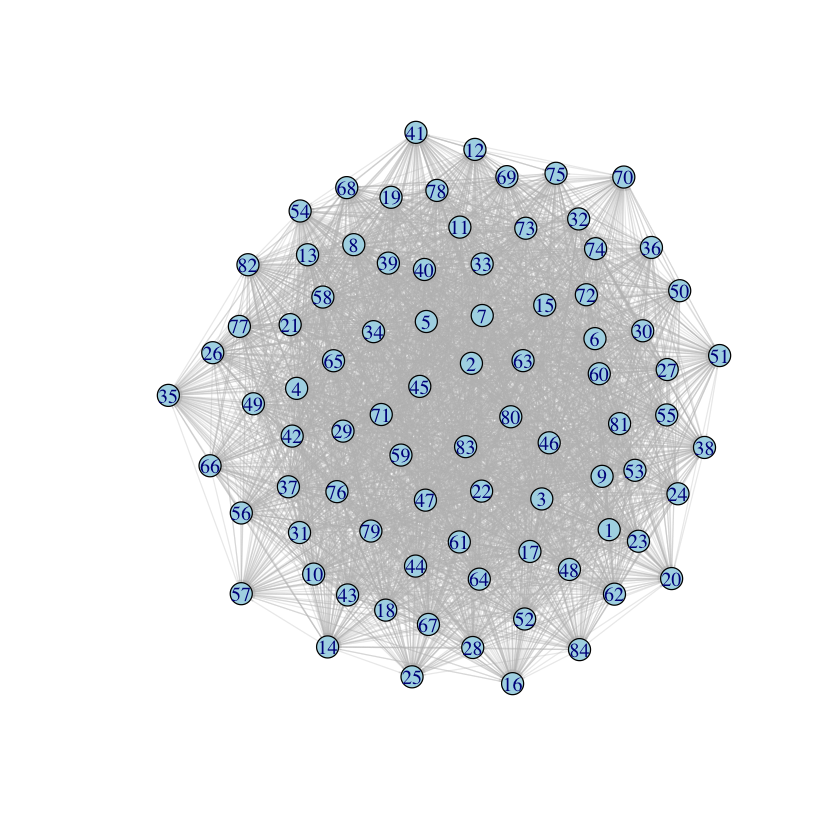

In [153]:
plot(graph,
     vertex.size = 8,         
     vertex.color = "lightblue",
     edge.arrow.size = 0.1, 
     edge.arrow.width = 0.3,
     edge.color = adjustcolor("gray", alpha.f = 0.3),
     layout = layout_with_fr)

### 3. Вычисление «пятичисловой сводки» для графа

In [154]:
adj_matrix <- as_adjacency_matrix(graph, sparse = FALSE)
net <- network(adj_matrix, matrix.type = "adjacency", directed = TRUE)

#a)размер сети
g1 <- network.size(net)

#b)плотность сети
gden(net)

#с)количество компонент связности
comp <- clusters(graph, mode = "strong")
comp$no 

#d)диаметр сети
lgc1 <- largest_component(graph, mode = "strong")
diameter(lgc1, directed = TRUE)

#e) коэффициент кластеризации
gtrans(net, mode = "disgraph")

[1] 0.5754446

[1] 1

[1] 2

[1] 0.5757862

### 4. Вычисление цензуса диад

In [140]:
census <- dyad.census(net)
census

M <- census[1, "Mut"]   
A <- census[1, "Asym"]      
N <- census[1, "Null"]    
L <- network.edgecount(net)
L

Mut,Asym,Null
1084,1725,677


[1] 3893

### 5.Вычисление оценки индекса взаимности Каца—Пауэла при фиксированом выборе акторов и при свободном выборе

In [163]:
out_degrees <- degree(net, gmode = "digraph", cmode = "outdegree") 
out_degrees
d <- mean(out_degrees)

# фиксированный выбор
numerator <- 2 * (g - 1) * M - g * d^2
denominator <- g * d * (g - 1 - d)
rho_kp <- numerator / denominator

rho_kp 

# свободный выбор
L2 <- sum(out_degrees^2)

numerator <- 2 * (g - 1)^2 * M - L^2 + L2
denominator <- L * (g - 1)^2 - L^2 + L2
rho_free <- numerator / denominator
rho_free

E_M_free <- (L^2 - L2) / (2 * (g - 1)^2)
M_max_free <- L / 2
rho_alt <- (M - E_M_free) / (M_max_free - E_M_free)
rho_alt

[1] 40 53 43 50 39 49 54 55 41 50 48 47 56 51 59 41 52 48 44 42 48 53 48 51 47
[26] 43 50 44 52 50 52 49 44 47 40 47 45 45 53 43 48 50 42 49 55 49 53 46 42 45
[51] 42 45 44 52 49 48 36 45 47 51 50 48 55 47 50 44 47 54 53 39 53 48 51 47 42
[76] 49 46 52 45 56 45 48 51 41

Mut 
-0.08259411

Mut 
-0.002252628

Mut 
-0.002252628

### 6.Вычисление вероятности того, что связь будет взаимной для каждого случая

In [164]:
d <- round(mean(out_degrees))

# фиксированный выбор
P_mut_fixed <- (d/(g-1))^2
P_mut_fixed

# свободный выбор
P_mut_free <- E_M_free / choose(g, 2)
P_mut_free

P_obs <- M / choose(g, 2)
P_obs

[1] 0.3344462

[1] 0.3115142

Mut 
0.3109581

### 7.Вычисление индекса взаимности Бондопаддхая

In [165]:
x_sorted <- sort(out_degrees, decreasing = TRUE)

f_values <- numeric(g+1)
f_values[1] <- 0  

cumulative_sum <- 0
for (t in 1:g) {
  cumulative_sum <- cumulative_sum + x_sorted[t]
  f_t <- cumulative_sum - t*(g-1) - choose(t, 2)
  f_values[t+1] <- f_t
}

M_min <- max(f_values)
max_t_f <- which.max(f_values) - 1


g_values <- numeric(g+1) 
g_values[1] <- 0

for (t in 1:g) {
  sum_first_t <- sum(x_sorted[1:t])
  term2 <- t*(t-1)
  
  sum_min <- 0
  if (t < g) {
    for (i in (t+1):g) {
      sum_min <- sum_min + min(t, x_sorted[i])
    }
  }
  
  g_t <- sum_first_t - term2 - sum_min
  g_values[t+1] <- g_t
}


max_g_value <- max(g_values)
max_t_g <- which.max(g_values) - 1

M_max <- floor((L - max_g_value) / 2)

rho_B <- (M - M_min) / (M_max - M_min)
rho_B 

Mut 
0.5570401

### 8.Проверить нулевую гипотезу о том, что число дуг 𝐿 в орграфе 𝒢𝑑 имеет биномиальное распределение Binom(𝑔(𝑔 − 1), 1/2) 

In [166]:
n <- g*(g-1)  
P0 <- 0.5 
E_L <- n * P0
Var_L <- n * P0 * (1 - P0)
sd_L <- sqrt(Var_L)

z <- (L - E_L) / sd_L
p_value <- 2 * pnorm(-abs(z))
alpha <- 0.2
reject_H0 <- abs(z) > qnorm(1 - alpha/2)

L
round(z, 4)
format.pval(p_value)
reject_H0
p_value # максималбный уровень значимости

[1] 3893

[1] 9.7487

[1] "< 2.22e-16"

[1] TRUE

[1] 1.868865e-22

### 9.Проверить нулевую гипотезу о том, что число дуг 𝐿 в орграфе 𝒢𝑑 имеет биномиальное распределение Binom(𝑔(𝑔 − 1), P0) 

In [167]:
P0 = 0.75
n <- g*(g-1)
E_L_H0 <- n * P0    
Var_L_H0 <- n * P0 * (1 - P0) 
sd_L_H0 <- sqrt(Var_L_H0) 
z <- (L - E_L_H0) / sd_L_H0
p_value <- 2 * pnorm(-abs(z))
c_value <- qnorm(1 - alpha/2)
reject_H0 <- abs(z) > c_value
reject_H0
p_value # максималбный уровень значимости

[1] TRUE

[1] 6.998389e-299

### 10.Построить доверительный интервал для оценки параметра 𝑝 с доверительной надёжностью 1 − 𝛼

In [168]:
p_hat <- L / n

z <- qnorm(1 - alpha/2) 

se <- sqrt(p_hat * (1 - p_hat) / n)

ci_lower <- p_hat - z * se
ci_upper <- p_hat + z * se

ci_lower
ci_upper

[1] 0.5507547

[1] 0.565998

### 11. Общий вывод

In [ ]:
#TODO